TODO: Pasamos de la clasificación, vamos a tratar el problema como uno de verificación de identidad, es decir, si dadas dos imágenes el modelo decide si ambas imágenes corresponden a la misma persona o no. Luego en la evaluación podemos calcular la distancia entre ellas y comparar. Ver ejemplo de *dissimilarity* en el notebook de siamesas con pytorch.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage

In [22]:
from torchvision.datasets import LFWPeople
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(256),                  # Redimensiona el lado más corto de la imagen a 256 píxeles
    transforms.CenterCrop(224),             # Recorta el centro de la imagen a 224x224
    transforms.ToTensor(),                  # Convierte la imagen en un tensor (valores entre [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Media de los canales RGB (preentrenada en ImageNet)
                         std=[0.229, 0.224, 0.225])   # Desviación estándar de los canales RGB (ImageNet)
])

lfw_dataset = LFWPeople(root='./data', split='train', transform=transform, download=True)

dataloader = DataLoader(lfw_dataset, batch_size=32, shuffle=True)

print(f"Número de imágenes: {len(lfw_dataset)}")
print(f"Shape de la primera imagen: {lfw_dataset[0][0].shape}")
print(f"Etiqueta de la primera imagen: {lfw_dataset[0][1]}")

Files already downloaded and verified
Número de imágenes: 9525
Shape de la primera imagen: torch.Size([3, 224, 224])
Etiqueta de la primera imagen: 0


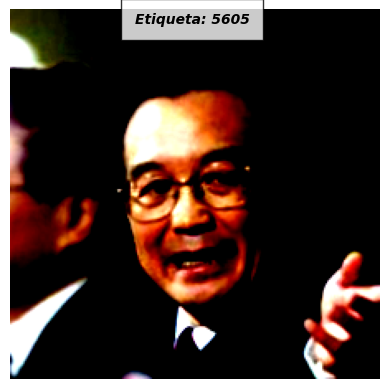

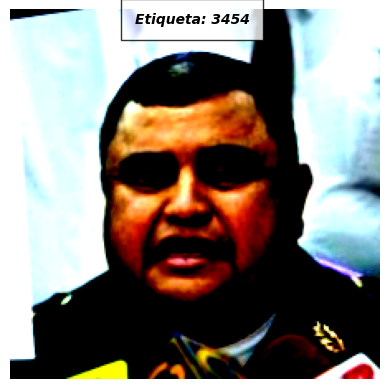

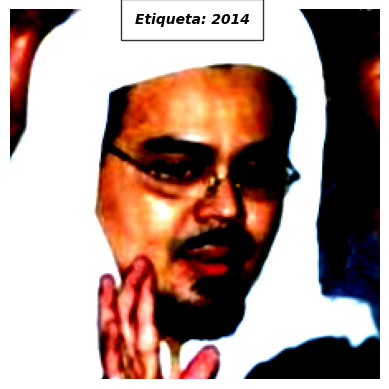

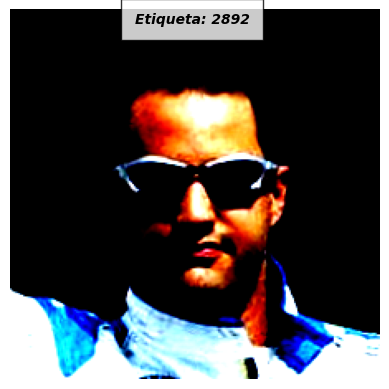

In [23]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iterations, losses):
    plt.plot(iterations, losses)
    plt.show()

for images, labels in dataloader:
    for i in range(4):
        imshow(images[i], text=f"Etiqueta: {labels[i]}")
    break

In [24]:
resnet18 = torchvision.models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
print(num_ftrs)

512


In [25]:
class SiameseDataset(Dataset):
    def __init__(self, dataset, transform=None):

        self.dataset = dataset
        self.transform = transform

        # Crear un diccionario de etiquetas a imágenes
        self.label_to_indices = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.dataset)

In [26]:
def select_pairs_online(images, labels):
    """
    Selecciona pares online usando la etiqueta de la clase positiva.
    Aleatoriamente escoge o una clase positva o negativa para el par
    """
    pairs = []
    for i in range(len(images)):
      label = labels[i]
      positive = torch.where(labels == label)[0]
      negative = torch.where(labels != label)[0]
      should_get_same_class = random.randint(0,1)
      if should_get_same_class:
          positive = random.choice(positive.tolist())
          idx = positive
      else:
          negative = random.choice(negative.tolist())
          idx = negative
      pairs.append((idx,np.float32(should_get_same_class)))

    return pairs

In [27]:
#create the Siamese Neural Network
class SiameseModel(nn.Module):
  def __init__(self, model):
    super(SiameseModel, self).__init__()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    self.model = model

  def forward_once(self, x):
    output = self.model(x)
    return output

  def forward(self, input1, input2):
      output1 = self.forward_once(input1)
      output2 = self.forward_once(input2)

      return output1, output2

In [28]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

In [29]:
train_dataloader = DataLoader(lfw_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=32)

In [30]:
net1 = SiameseModel(model = resnet18)
criterion = ContrastiveLoss(margin = 0.2)
optimizer = optim.Adam(net1.parameters(), lr = 0.0005 )

In [31]:
counter = []
triplet_history = []
iteration_number= 0
net1.cuda()

if torch.cuda.is_available():
    print("GPU disponible")
else:
    print("GPU no disponible")

# Iterate throught the epochs
for epoch in range(5):
  epoch_loss = 0

  # Iterate over batches
  for images, labels in train_dataloader:

    images = images.cuda()
    labels = labels.cuda()

    pairs = select_pairs_online(images, labels)

    pair_idx, pair_labels = zip(*pairs)
    pair_labels = torch.tensor(pair_labels, device='cuda', dtype=torch.float32)

    p_embeddings = net1.forward_once(images).cuda()
    n_embeddings = torch.stack([lfw_dataset[idx][0] for idx in pair_idx]).cuda()
    n_embeddings = net1.forward_once(n_embeddings).cuda()

    # Calcular pérdida
    pair_labels = torch.tensor(pair_labels, dtype=torch.float32)
    loss = criterion(p_embeddings, n_embeddings, pair_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()

    epoch_loss += loss.item()

  print(f"Epoch [{epoch+1}/{10}], Loss: {epoch_loss/len(train_dataloader):.4f}")

GPU disponible


<ipython-input-31-6b6b215c1e40>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pair_labels = torch.tensor(pair_labels, dtype=torch.float32)


Epoch [1/10], Loss: 0.0451
Epoch [2/10], Loss: 0.0110
Epoch [3/10], Loss: 0.0105
Epoch [4/10], Loss: 0.0104
Epoch [5/10], Loss: 0.0104


In [66]:
from torch.nn.functional import pairwise_distance

def evaluate(model, dataloader, threshold=0.5):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            pairs = select_pairs_online(images, labels)
            pair_images, pair_labels = zip(*pairs)
            pair_labels = torch.tensor(pair_labels, device='cuda', dtype=torch.float32)

            # Preprocesar imágenes
            images = images.to(device)
            pair_images = torch.stack([lfw_dataset[idx][0] for idx in pair_idx]).to(device)

            # Generar embeddings
            embeddings1 = net1.forward_once(images)
            embeddings2 = net1.forward_once(pair_images)

            # Calcular distancias
            distances = pairwise_distance(embeddings1, embeddings2)
            predictions = (distances < threshold).float()

            # Comparar con etiquetas reales
            total += pair_labels.size(0)
            correct += (predictions == pair_labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

evaluate(net1, train_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


RuntimeError: The size of tensor a (32) must match the size of tensor b (21) at non-singleton dimension 0

AQUI PROBAMOS CAMBIANDO LA FC Y CLASIFICANDO (El primer experimento sale horrible con 5% de accuracy, el dataset no ayuda mucho).

In [32]:
num_classes = len(lfw_dataset.class_to_idx)
num_classes

5749

In [33]:
net1.model.fc = nn.Linear(net1.model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_resnet = net1.to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)

In [35]:
num_epochs = 20
for epoch in range(num_epochs):
    siamese_resnet.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = net1.forward_once(images)
        loss = criterion(outputs, labels)

        # Backward y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

Epoch [1/20], Loss: 8.2862
Epoch [2/20], Loss: 7.3141
Epoch [3/20], Loss: 7.0250
Epoch [4/20], Loss: 6.7886
Epoch [5/20], Loss: 6.4946
Epoch [6/20], Loss: 6.1335
Epoch [7/20], Loss: 5.6378
Epoch [8/20], Loss: 5.0199
Epoch [9/20], Loss: 4.2779
Epoch [10/20], Loss: 3.4194
Epoch [11/20], Loss: 2.4916
Epoch [12/20], Loss: 1.5697
Epoch [13/20], Loss: 0.8438
Epoch [14/20], Loss: 0.3996
Epoch [15/20], Loss: 0.1742
Epoch [16/20], Loss: 0.0628
Epoch [17/20], Loss: 0.0266
Epoch [18/20], Loss: 0.0157
Epoch [19/20], Loss: 0.1088
Epoch [20/20], Loss: 0.4485


In [36]:
net1.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net1.forward_once(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy in train: {100 * correct / total:.2f}%')

Accuracy in train: 94.90%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


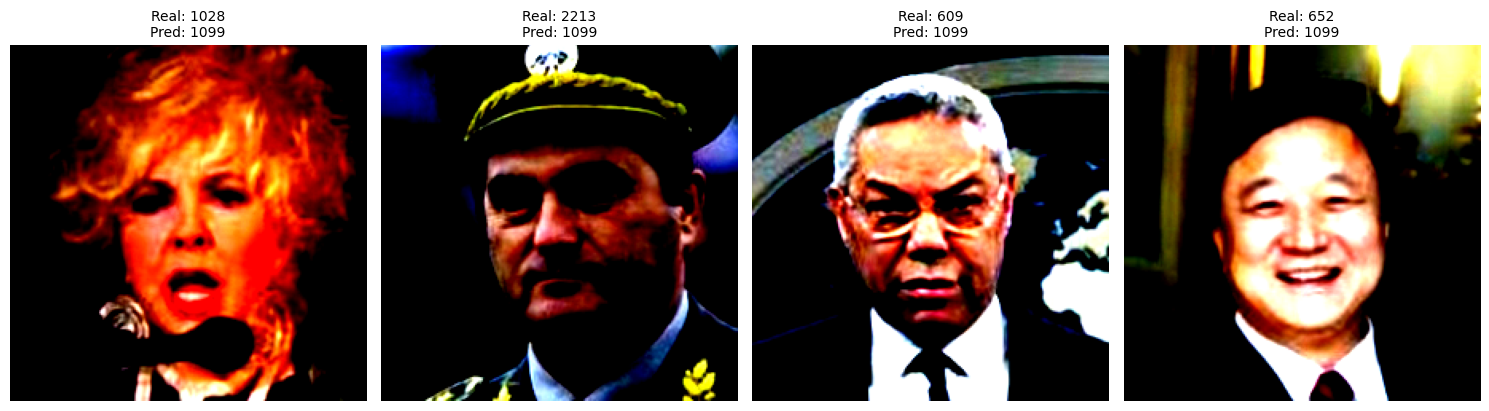

In [53]:
def imshow_with_predictions(images, labels, predictions, class_names):
    images = images.cpu().numpy()  # Convertir a numpy
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

    for idx, ax in enumerate(axes):
        image = np.transpose(images[idx], (1, 2, 0))

        # Etiquetas reales y predicciones
        true_label = class_names[labels[idx]]
        pred_label = class_names[predictions[idx]]

        # Mostrar imagen y texto
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Real: {true_label}\nPred: {pred_label}", fontsize=10)

    plt.tight_layout()
    plt.show()

train_dataloader = DataLoader(lfw_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=4)

# Obtener un lote de datos del val_loader
data_iter = iter(train_dataloader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = net1.forward_once(images)
_, predictions = torch.max(outputs, 1)

# Mostrar imágenes con predicciones y etiquetas reales
class_names = lfw_dataset.targets
imshow_with_predictions(images, labels, predictions, class_names)

In [37]:
lfw_dataset_test = LFWPeople(root='./data', split='test', transform=transform, download=True)
print(len(lfw_dataset_test))

Files already downloaded and verified
3708


In [38]:
test_dataloader = DataLoader(lfw_dataset_test, batch_size=32, shuffle=True)

net1.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net1.forward_once(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy in test: {100 * correct / total:.2f}%')

Accuracy in test: 0.00%
